In [1]:
!pip install ipykernel transformer_lens plotly 

In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=9

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=9


In [2]:
import transformer_lens
import torch
# import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, FactoredMatrix
# Import stuff
import torch
import torch.nn as nn
import einops
from fancy_einsum import einsum
import tqdm.auto as tqdm
import plotly.express as px
import numpy as np

from jaxtyping import Float
from functools import partial
import numpy as np
import random

/nlp/projekty/aver/xspiege1/algorithmic_reasoning/.env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Convert HF Transformers weights to HookedTransformer weights

In [3]:
"""
from transformer_lens.pretrained.weight_conversions.llama import convert_llama_weights
from transformers import AutoConfig, AutoModelForCausalLM

config = AutoConfig.from_pretrained("meta-llama/Llama-3.2-1B-Instruct")
model = AutoModelForCausalLM.from_config(config)
model.load_state_dict(torch.load("checkpoints/llama_instruct_value_assign_finetuned_new.weights", weights_only=True))
hooked_config = transformer_lens.loading.get_pretrained_model_config("meta-llama/Llama-3.2-1B-Instruct")
new_state_dict = convert_llama_weights(model, hooked_config)
torch.save(new_state_dict, "checkpoints/llama_instruct_value_assign_finetuned_hooked_new.weights")

"""

'\nfrom transformer_lens.pretrained.weight_conversions.llama import convert_llama_weights\nfrom transformers import AutoConfig, AutoModelForCausalLM\n\nconfig = AutoConfig.from_pretrained("meta-llama/Llama-3.2-1B-Instruct")\nmodel = AutoModelForCausalLM.from_config(config)\nmodel.load_state_dict(torch.load("checkpoints/llama_instruct_value_assign_finetuned_new.weights", weights_only=True))\nhooked_config = transformer_lens.loading.get_pretrained_model_config("meta-llama/Llama-3.2-1B-Instruct")\nnew_state_dict = convert_llama_weights(model, hooked_config)\ntorch.save(new_state_dict, "checkpoints/llama_instruct_value_assign_finetuned_hooked_new.weights")\n\n'

In [4]:
config = transformer_lens.loading.get_pretrained_model_config("meta-llama/Llama-3.2-1B-Instruct")
model = transformer_lens.HookedTransformer(config)
model.load_and_process_state_dict(torch.load("checkpoints/llama_instruct_value_assign_finetuned_hooked_new.weights", weights_only=True))
#config = transformer_lens.loading.get_pretrained_model_config("Qwen/Qwen2.5-1.5B-Instruct")
#model = transformer_lens.HookedTransformer(config)
#model.load_and_process_state_dict(torch.load("checkpoints/Qwen2.5-1.5B-Instruct_value_assign_finetuned_hooked.weights", weights_only=True))


In [5]:
print(model)

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (blocks): ModuleList(
    (0-15): 16 x TransformerBlock(
      (ln1): RMSNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): RMSNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): GroupedQueryAttention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
        (hook_rot_k): HookPoint()
        (hook_rot_q): HookPoint()
      )
      (mlp): GatedMLP(
        (hook_pre): HookPoint()
        (hook_pre_linear): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out)

In [6]:
test_prompt = "The quick brown fox jumped over the lazy dog"
print("Num tokens:", len(model.to_tokens(test_prompt)[0]))

def print_name_shape_hook_function(activation, hook):
    print(hook.name, activation.shape)

not_in_late_block_filter = lambda name: name.startswith("blocks.0.") or not name.startswith("blocks")

model.run_with_hooks(
    test_prompt,
    return_type=None,
    fwd_hooks=[(not_in_late_block_filter, print_name_shape_hook_function)],
)

Num tokens: 10
hook_embed torch.Size([1, 10, 2048])
blocks.0.hook_resid_pre torch.Size([1, 10, 2048])
blocks.0.ln1.hook_scale torch.Size([1, 10, 1])
blocks.0.ln1.hook_normalized torch.Size([1, 10, 2048])
blocks.0.ln1.hook_scale torch.Size([1, 10, 1])
blocks.0.ln1.hook_normalized torch.Size([1, 10, 2048])
blocks.0.ln1.hook_scale torch.Size([1, 10, 1])
blocks.0.ln1.hook_normalized torch.Size([1, 10, 2048])
blocks.0.attn.hook_q torch.Size([1, 10, 32, 64])
blocks.0.attn.hook_k torch.Size([1, 10, 8, 64])
blocks.0.attn.hook_v torch.Size([1, 10, 8, 64])
blocks.0.attn.hook_rot_q torch.Size([1, 10, 32, 64])
blocks.0.attn.hook_rot_k torch.Size([1, 10, 8, 64])
blocks.0.attn.hook_attn_scores torch.Size([1, 32, 10, 10])
blocks.0.attn.hook_pattern torch.Size([1, 32, 10, 10])
blocks.0.attn.hook_z torch.Size([1, 10, 32, 64])
blocks.0.hook_attn_out torch.Size([1, 10, 2048])
blocks.0.hook_resid_mid torch.Size([1, 10, 2048])
blocks.0.ln2.hook_scale torch.Size([1, 10, 1])
blocks.0.ln2.hook_normalized torc

In [7]:
charset_from = ""
for id in range(0, 50000):
    token = model.tokenizer.decode(id, skip_special_tokens=True)
    if len(token) > 1 or token == "�":
        continue
    decode_id = model.tokenizer.encode(token, add_special_tokens=False)
    if len(decode_id) == 1 and decode_id[0] == id:
        charset_from += token

In [8]:
unseen_charset = charset_from[105:]
unseen_10_chars = random.choices(unseen_charset, k=10)

In [27]:
import sys
sys.path.insert(0, "..")
sys.path.insert(0, "../generators")
sys.path.insert(0, "generators")


from generators.value_assignment import ValueAssignmentGenerator
import transformers
import itertools


data_generator = ValueAssignmentGenerator(tokenizer=model.tokenizer,
                                       seed=0,
                                       use_few_shot=True, 
                                       use_instruction=True, 
                                       apply_chat_template=True,
                                       length=(10, 10),
                                       encoding_length=(30, 30),
                                       #charset_from=unseen_charset
                                       charset_to=unseen_charset
                                       )
samples = itertools.islice(data_generator.generate_samples(), 30)

In [28]:
samples = list(samples)
texts = [sample[0] for sample in samples]
input_ids = [sample[1] for sample in samples]
target_ids = [sample[2] for sample in samples]
attn_labels = [sample[3] for sample in samples]

In [29]:
texts[0]

'<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 19 May 2025\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\n\nYou are a great problem solver excellent in tasks requiring manipulation of symbols. You will be tasked with encoding a sequence of characters given a set of encodings. \nAn encoding is a tuple of characters, e.g. A1, where A is the character to be encoded, and 1 is its encoding. For example, given some string "A", its encoding is a sequence "1". \nGiven a set of these encodings and an input string, encode this string.\nDo not generate any words. You can only generate characters from the set of encodings.\nHere are some examples:\nH3K8U1D5G9F1 HKKHDFG=3883519\nABCDEFGHIJKL ACEGIK=BDFHJLUse them to solve the following task:\n\x04题W´&்C监cН`ọUリH公_ตO位lв<세b\x192月F化|学-\x0cq象Bρf关o以3登Iêyф*μL지^改i\u200br试\x01円 &O|iC-3-*-=<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n்位学\u200b监\x0c登\x0cμ\x0c<|eot_id|>

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import random
import plotly.graph_objects as go


def visualize_attention_heads(attention_matrix, tokens=None, title="Attention Heatmap", save_path=None, heads=None, length=None, attn_labels=None):
    """
    Visualize a multi-head attention matrix as heatmaps for each head.

    Parameters:
        attention_matrix (torch.Tensor): Tensor of shape (1, num_heads, seq_len, seq_len).
        tokens (list, optional): List of tokens corresponding to the rows/columns of the matrix.
        title (str): Title of the heatmap.
        save_path (str, optional): Path to save the heatmap images. If None, the heatmaps are not saved.
        heads (list, optional): List of head indices to visualize.
        length (int, optional): Number of tokens to display from the lower-right corner.
"""
    scores = attention_matrix.squeeze(0).cpu().detach().numpy()  # Shape: (num_heads, seq_len, seq_len)
    num_heads = scores.shape[0]
    seq_len = scores.shape[1]

    for head in range(num_heads):
        if heads is not None and head not in heads:
            continue
        head_scores = scores[head]  # Shape: (seq_len, seq_len)

        # Apply filtering for the lower-right "length x length" square
        if length is not None and length < seq_len:
            head_scores = head_scores[-length:, -length:]
            if tokens:
                tokens = tokens[-length:]
            if attn_labels is not None:
                attn_labels = attn_labels[-length:, -length:]

        # Normalize scores for better visualization
        min_score = head_scores.min()
        max_score = head_scores.max()
        normalized = (head_scores - min_score) / (max_score - min_score)  # Normalize to [0, 1]

        # Create the heatmap
        fig = go.Figure(
            data=go.Heatmap(
                z=normalized,
                x=tokens if tokens else list(range(len(normalized))),
                y=tokens if tokens else list(range(len(normalized))),
                colorscale="Viridis",
                colorbar=dict(title="Attention Score"),
            )
        )

        # Add title and layout
        fig.update_layout(
            title=f"{title} - Head {head + 1}",
            xaxis=dict(title="Tokens", tickangle=45),
            yaxis=dict(title="Tokens"),
        )

        # Highlight attention label regions if provided
        if attn_labels is not None:
            for i in range(len(attn_labels)):
                for j in range(len(attn_labels)):
                    if attn_labels[i, j] == 1:
                        fig.add_shape(
                            type="rect",
                            x0=j - 0.5,
                            x1=j + 0.5,
                            y0=i - 0.5,
                            y1=i + 0.5,
                            line=dict(color="red", width=2),
                        )

        # Save the plot if a save path is provided
        if save_path:
            fig.write_image(f"{save_path}_head_{head + 1}.png")

        # Show the plot
        fig.show()

In [31]:
from torch.nn.functional import cosine_similarity

sim_scores = [[]]

def compute_scores(logits, target):
    ignore_index = -100  # Optional: index to ignore in loss/accuracy computation
    # Compute loss
    loss = torch.nn.functional.cross_entropy(
    logits.view(-1, logits.size(-1)),  # Flatten logits to (batch_size * seq_len, vocab_size)
    target.view(-1),               # Flatten target_ids to (batch_size * seq_len)
    ignore_index=ignore_index          # Ignore padding tokens if applicable
)

    # Compute accuracy
    predictions = torch.argmax(logits, dim=-1)  # Get predicted token indices
    correct = (predictions == target) & (target != ignore_index)  # Ignore padding tokens
    accuracy = correct.sum().item() / (target != ignore_index).sum().item()

    print(f"Loss: {loss.item()}, Accuracy: {accuracy:.2%}")

    errors = (predictions != target) & (target != ignore_index)  # Identify error positions
    errors_np = errors.cpu().numpy()  # Convert to NumPy for visualization
    #print("Errors:", errors_np)

    return loss.item(), accuracy

@torch.no_grad
def inspect_representations(
    value: Float[torch.Tensor, "batch pos head_index d_head"],
    hook: HookPoint,
    target_ids: torch.Tensor,
    model: HookedTransformer
) -> Float[torch.Tensor, "batch pos head_index d_head"]:
    batch, seq_len, d_model = value.shape
    layer = int(hook.name.split(".")[1])  # Extract layer number from hook name
    #print(f"Inspecting layer {layer}, value shape: {value.shape}")

    # Mask out positions where target_ids == -100
    valid_positions = target_ids != -100  # Shape: (batch, pos)
    valid_positions = valid_positions
    # Get the embedding matrix from the model
    embedding_matrix = model.embed.W_E  # Shape: (vocab_size, d_model)

    # Get the embeddings for the valid target_ids
    target_embeddings = embedding_matrix[target_ids[valid_positions]]  # Shape: (batch, pos, d_model)

    # Compute cosine similarity between current representations and target embeddings
    similarity_scores = cosine_similarity(value[valid_positions.unsqueeze(0)], target_embeddings, dim=-1)  # Shape: (batch, pos)
    sim_scores[-1].append(similarity_scores.tolist())
    # Log or return the similarity scores
    #print(f"Similarity scores (layer {layer}): {similarity_scores}")
    return value


device = "cuda"

is_attn_result = lambda name: name.endswith("hook_attn_out")
is_mlp_result = lambda name: name.endswith("mlp_out")
is_resid_post = lambda name: name.endswith("hook_resid_post")

ablated = []
for idx in range(9, 10):



    
    indices =  np.argwhere(attn_labels[idx].cpu().numpy() == 1)
    attn_labels_1_idx = set(map(tuple, indices))
    

    model.to(device)
    input_ids[idx] = input_ids[idx].to(device)
    target_ids[idx] = target_ids[idx].to(device)
    attn_labels[idx] = attn_labels[idx].to(device)
                

    heads_to_reinforce_x=[
        (7, [5]),
        (8, [20, 31]),
        (9, [8, 10]),
        (10, [23, 20, 21, 1, 22]),
        (11, [14, 20, 4]),
        (12, [13, 2, 29]),
        (13, [20, 21, 22, 2, 23, 31, 1, 11]),
        (14, [22, 11, 20, 15, 21, 14, 31, 3, 28, 29]),
        (15, [31, 7, 22, 30, 20, 29]),
    ]

    cols_to_keep = ~np.all(attn_labels[idx].cpu().numpy() == -100, axis=0)
    keep_last_n_tokens = 400
    heads_x = dict(heads_to_reinforce_x)
    logits = model.run_with_hooks(input_ids[idx], return_type="logits",
                                    fwd_hooks=[
                                        (is_attn_result, partial(inspect_representations, target_ids=target_ids[idx], model=model)),
                                        (is_mlp_result, partial(inspect_representations, target_ids=target_ids[idx], model=model)),
                                        (is_resid_post, partial(inspect_representations, target_ids=target_ids[idx], model=model)),
                                    ])
    loss, acc = compute_scores(logits, target_ids[idx])
    ablated.append((heads_x, loss, acc))
    del logits
    torch.cuda.empty_cache()
    sim_scores.append([])
    

Moving model to device:  cuda
Loss: 1.504478931427002, Accuracy: 54.55%


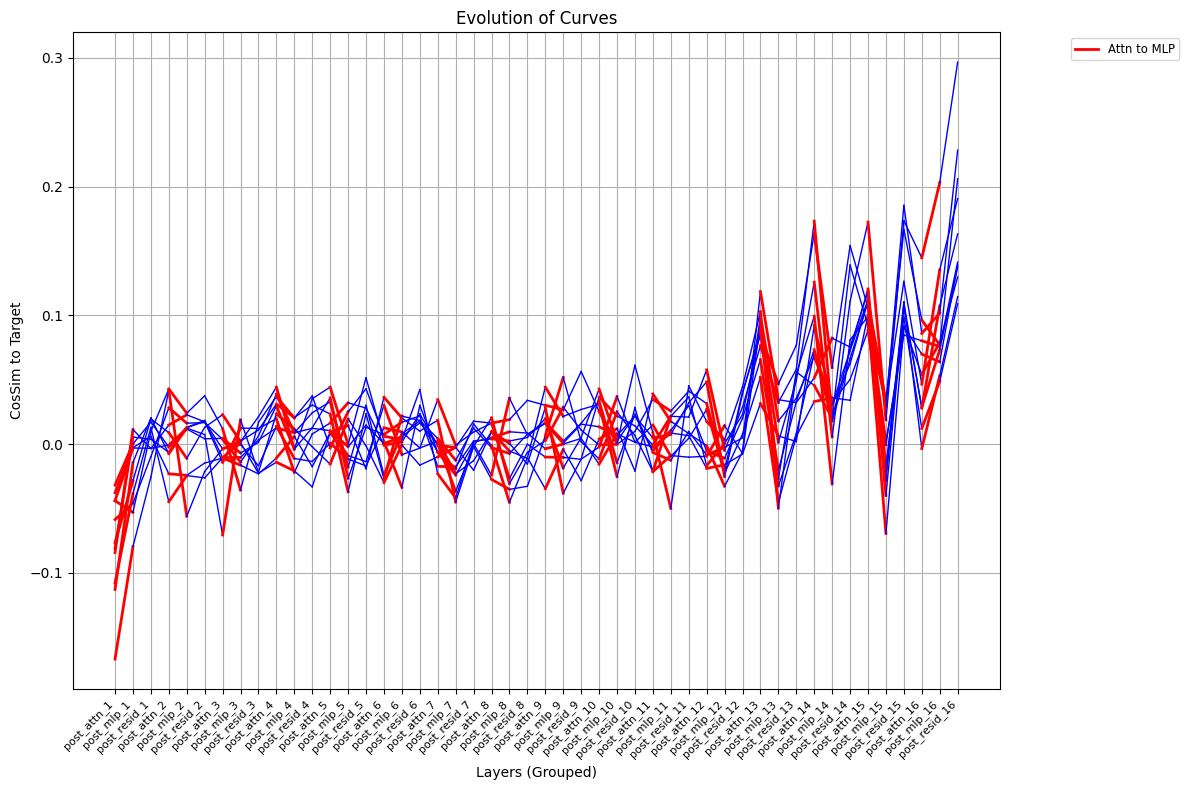

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

def plot_evolution(data, title="Evolution of Curves", ylabel="CosSim to Target"):
    """
    Plot the evolution of curves over steps, highlighting the transitions from post_attn to post_mlp.

    Args:
        data (list of lists): A list where each internal list contains float values.
        title (str): Title of the plot.
        ylabel (str): Label for the Y-axis.
    """
    # Convert the data to a NumPy array for easier manipulation
    data = np.array(data)  # Shape: (num_steps, num_curves)
    num_steps, num_curves = data.shape

    # Ensure the number of steps is divisible by 3 for grouping
    assert num_steps % 3 == 0, "Number of steps must be divisible by 3 for grouping."

    # Generate custom X-axis labels
    num_groups = num_steps // 3
    x_labels = []
    for i in range(num_groups):
        x_labels.extend([f"post_attn_{i+1}", f"post_mlp_{i+1}", f"post_resid_{i+1}"])

    # Plot each curve
    plt.figure(figsize=(12, 8))
    for i in range(num_curves):
        for j in range(num_steps - 1):
            # Highlight transitions from post_attn to post_mlp
            if j % 3 == 0:  # Transition from post_attn to post_mlp
                plt.plot(
                    [j, j + 1],
                    [data[j, i], data[j + 1, i]],
                    color="red",
                    linewidth=2,
                    label="Attn to MLP" if i == 0 and j == 0 else None,  # Add label only once
                )
            else:
                plt.plot(
                    [j, j + 1],
                    [data[j, i], data[j + 1, i]],
                    color="blue",
                    linewidth=1,
                )

    # Add custom X-axis labels
    plt.xticks(ticks=range(num_steps), labels=x_labels, rotation=45, ha="right", fontsize=8)

    # Add labels, title, and legend
    plt.title(title)
    plt.xlabel("Layers (Grouped)")
    plt.ylabel(ylabel)
    plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.0), fontsize="small")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage
# Simulated data: 9 steps (3 groups), 5 curves
data = [
    [np.sin(i / 10 + j) for j in range(5)] for i in range(9)
]

for i in range(0, 1):
    plot_evolution(sim_scores[i])

In [33]:
sums = 0
for item in ablated:
    sums += item[2]
print(sums/len(ablated))
print(sums)

0.5454545454545454
0.5454545454545454


In [27]:
for item in sorted(best_heads.items(), key=lambda item: item[1], reverse=True):
    print(item[0][0], item[0][1], item[1].item())

NameError: name 'best_heads' is not defined